## Set up

### Define functions

In [1]:
#@title
import tempfile
from urllib import request
import sqlite3

from typing import Dict

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
%matplotlib inline

import seaborn as sns
sns.set()

#%load_ext google.colab.data_table

# Set float display options for pandas dataframes.
pd.options.display.float_format = "{:,.2f}".format

def excel_dataset_to_sqlite(url: str, database_name: str = ":memory:") -> sqlite3.Connection:
  """Downloads an excel dataset and loads it into an sqlite database."""

  # Download the data into a local variable.
  data = request.urlopen(url).read()

  # Write it out to afiles
  with tempfile.TemporaryFile() as fle:
    fle.write(data)

    # Read into pandas from excel file.
    data = pd.read_excel(fle, sheet_name=None)

  # Create a database.
  conn = sqlite3.connect(database_name)

  # Loads data from pandas objects into individual tables.
  for (key, sheet) in data.items():
    sheet = sheet.where(pd.notnull(sheet), None)
    sheet.to_sql(key, conn)


  # Return database.
  return conn

### Prepare the data

#### Import the dataset and create the database

The data comes from Research Excellence Framework 2014. It is an Excel workbook with two worksheets. The main worksheet contains the core data from the REF, the second worksheet provides some information about the REF.

I download the file from this [URL](https://public.tableau.com/s/sites/default/files/media/Resources/Research%20Excellence%20Framework%202014%20Results_Pivoted.xlsx"), and convert it into an SQL database to enable analysis in Jupyter Notebooks.

In [2]:
database = excel_dataset_to_sqlite("https://public.tableau.com/s/sites/default/files/media/Resources/Research%20Excellence%20Framework%202014%20Results_Pivoted.xlsx")

/Users/Matthew/Library/Caches/pypoetry/virtualenvs/notebooks-IW0Gw3EE-py3.8/lib/python3.8/site-packages/pandas/core/generic.py:2779: UserWarning: The spaces in these column names will not be changed. In pandas versions < 0.14, spaces were converted to underscores.
  sql.to_sql(


Once the database has been created, I change the names of some of the tables and columns to make the data easier to work with.

In [3]:
#@title
database.execute(
    """ALTER TABLE 'Sheet1-Tableau' RENAME TO REF_Results;""")

In [4]:
#@title
database.execute("""Alter Table REF_Results
   Rename Column `Institution Code (UKPRN)` To Institution_Code;""")

database.execute("""Alter Table REF_Results
   Rename Column `Institution Name` To Institution_Name;""")

database.execute("""Alter Table REF_Results
   Rename Column `Institution Sort Order` To Institution_Sort_Order;""")

database.execute("""Alter Table REF_Results
   Rename Column `Main Panel` To Main_Panel;""")

database.execute("""Alter Table REF_Results
   Rename Column `Unit of Assessment Number` To Unit_of_Assessment_Number;""")

database.execute("""Alter Table REF_Results
   Rename Column `Unit of Assessment Name` To Unit_of_Assessment_Name;""")

database.execute("""Alter Table REF_Results
   Rename Column `FTE Category A staff submitted` To FTE_Category_A_staff_submitted;""")

database.execute("""Alter Table REF_Results
   Rename Column `Star Rating` To Star_Rating;""")

database.execute("""Alter Table REF_Results
   Rename Column `Joint submission` To Joint_submission;""")


## Understand the data

There is one table of interest: REF_Resutls. The table has 38,220 rows and 14 columns. REF_Results contains data about the universities assessed in the REF, the subjects they were assessed in, how many staff were submitted, the ratings they receieved, and whether universities completed joint submissions with another institution.

In [5]:
pd.read_sql("""
    SELECT *
    FROM REF_Results;""", database)

,index,Institution_Code,Institution_Name,Institution_Sort_Order,Main_Panel,Unit_of_Assessment_Number,Unit_of_Assessment_Name,Multiple submission letter,Multiple submission name,Joint_submission,Profile,FTE_Category_A_staff_submitted,Star_Rating,Percentage
0,0,10000291,Anglia Ruskin University,10,A,3,"Allied Health Professions, Dentistry, Nursing ...",,None,None,Outputs,11.30,4*,6.4
1,1,10000291,Anglia Ruskin University,10,A,3,"Allied Health Professions, Dentistry, Nursing ...",,None,None,Outputs,11.30,3*,68.1
2,2,10000291,Anglia Ruskin University,10,A,3,"Allied Health Professions, Dentistry, Nursing ...",,None,None,Outputs,11.30,2*,25.5
3,3,10000291,Anglia Ruskin University,10,A,3,"Allied Health Professions, Dentistry, Nursing ...",,None,None,Outputs,11.30,1*,0
4,4,10000291,Anglia Ruskin University,10,A,3,"Allied Health Professions, Dentistry, Nursing ...",,None,None,Outputs,11.30,unclassified,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
38215,38215,10007807,University of Ulster,7630,D,36,"Communication, Cultural and Media Studies, Lib...",,None,None,Overall,16.40,4*,21
38216,38216,10007807,University of Ulster,7630,D,36,"Communication, Cultural and Media Studies, Lib...",,None,None,Overall,16.40,3*,39
38217,38217,10007807,University of Ulster,7630,D,36,"Communication, Cultural and Media Studies, Lib...",,None,None,Overall,16.40,2*,22
38218,38218,10007807,University of Ulster,7630,D,36,"Communication, Cultural and Media Studies, Lib...",,None,None,Overall,16.40,1*,12


In [6]:
pd.read_sql("""
    SELECT COUNT(DISTINCT Institution_Name) AS Institutions,
           COUNT(DISTINCT Unit_of_Assessment_Name) AS Units_of_Assessment,
           COUNT(DISTINCT Profile) AS Profiles,
           COUNT(DISTINCT Star_Rating) AS Star_Ratings
           FROM REF_Results;""", database)


,Institutions,Units_of_Assessment,Profiles,Star_Ratings
0,154,36,4,5


## Which universities were assessed across the widest range of subjects?

We know there are 36 unique subjects (units of assessment) in the database. No single institution was assessed on all of them - UCL has the widest range at 32 of the 36 subjects - and some universities were only assessed in one subject.

In [7]:
result = pd.read_sql(
    """SELECT Institution_Name, COUNT(DISTINCT Unit_of_Assessment_Name)
       FROM REF_Results
       GROUP BY Institution_Name
       ORDER BY COUNT(DISTINCT Unit_of_Assessment_Name) DESC
       LIMIT 20;""", database)

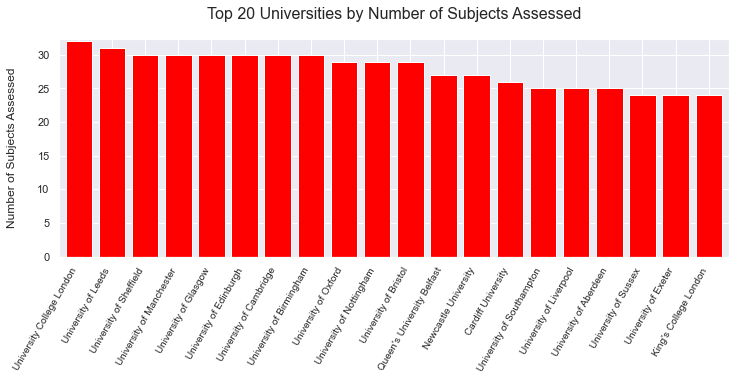

In [8]:
plt.figure(figsize=(12, 4))
plt.bar(x=result["Institution_Name"], height=result["COUNT(DISTINCT Unit_of_Assessment_Name)"], color='red')
plt.title("Top 20 Universities by Number of Subjects Assessed", pad = 20, fontsize = 16)
plt.ylabel("Number of Subjects Assessed", labelpad=20, fontsize = 12)
_ = plt.xticks(rotation = 60, ha = "right", fontsize = 10)
#plt.axhline(result["number_data_points"].mean(), color='blue', linewidth=2, label = "# Countries")
#plt.legend()
plt.margins(0.01, 0.01)

We can look at the distribution of universities based on the number of subjects they were assessed on. Most universities were assessed on only a small number of subjects, with 26 universities having been evaluated in only one subject. 

In [9]:
result = pd.read_sql(
    """WITH Institutions_By_Assessment_Count AS 
         (SELECT Institution_Name, 
          COUNT(DISTINCT Unit_of_Assessment_Name) AS Number_of_Assessment_Units
          FROM REF_Results GROUP BY Institution_Name)
                
        SELECT DISTINCT Number_of_Assessment_Units,
               COUNT(DISTINCT Institution_Name) AS Number_of_Institutions,
               SUM(COUNT(DISTINCT Institution_Name)) OVER 
                  (ORDER BY Number_of_Assessment_Units
                   ROWS BETWEEN UNBOUNDED PRECEDING AND CURRENT ROW) 
                   AS Running_Total
        FROM Institutions_By_Assessment_Count
        GROUP BY Number_of_Assessment_Units
        ORDER BY Number_of_Assessment_Units ASC;""", database)

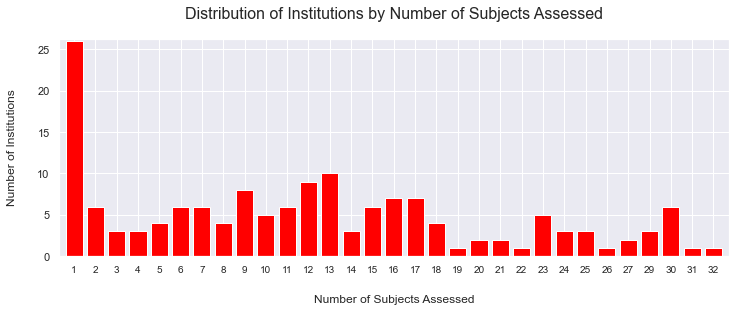

In [10]:
plt.figure(figsize=(12, 4))
plt.bar(x=result["Number_of_Assessment_Units"].astype(str), height=result["Number_of_Institutions"], color='red')
plt.title("Distribution of Institutions by Number of Subjects Assessed", pad = 20, fontsize = 16)
plt.xlabel("Number of Subjects Assessed", labelpad=20, fontsize = 12)
plt.ylabel("Number of Institutions", labelpad=20, fontsize = 12)
_ = plt.xticks(rotation = 0, ha = "center", fontsize = 10)
plt.margins(0.01, 0.01)

## And which subjects are the most common among the universities assessed?

In [11]:
result = pd.read_sql("""
        SELECT Unit_of_Assessment_Name,
               COUNT(DISTINCT Institution_Name) AS Number_of_Institutions
        FROM REF_Results
        GROUP BY Unit_of_Assessment_Name
        ORDER BY COUNT(DISTINCT Institution_Name) DESC;""", database)

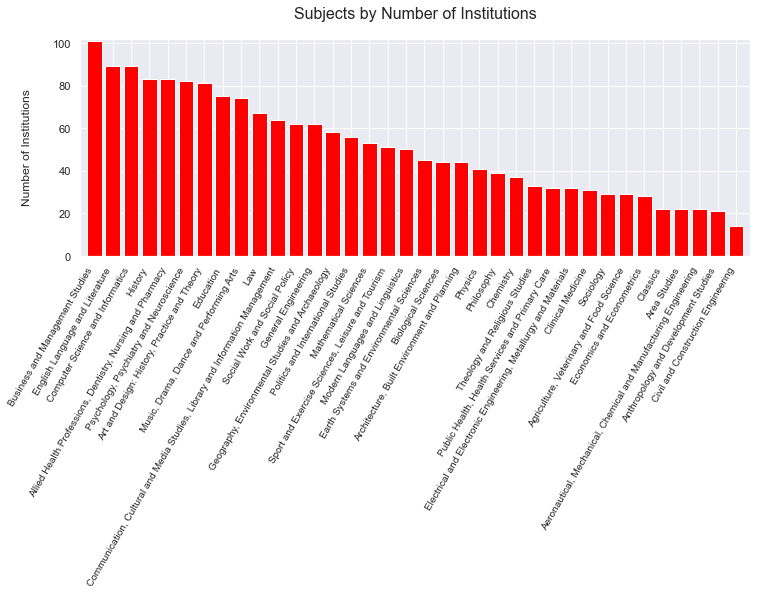

In [12]:
plt.figure(figsize=(12, 4))
plt.bar(x=result["Unit_of_Assessment_Name"].astype(str), height=result["Number_of_Institutions"], color='red')
plt.title("Subjects by Number of Institutions", pad = 20, fontsize = 16)
plt.ylabel("Number of Institutions", labelpad=20, fontsize = 12)
_ = plt.xticks(rotation = 60, ha = "right", fontsize = 10)
plt.margins(0.01, 0.01)

## Which universities perform the best in the assessment?

Based on the data available, there are several ways we could try to establish which university performed the best across the assessment.

The REF assesses submitted research and awards it a classification based on its quality. One of five quality ratings is possible: 

 - **Four star**: Quality that is world-leading in originality, significance and rigour.
 - **Three star**: Quality that is internationally excellent in originality, significance and rigour but which falls short of the highest standards of excellence.
 - **Two star**: Quality that is recognised internationally in originality, significance and rigour.
 - **One star**: Quality that is recognised nationally in originality, significance and rigour.
 - **Unclassified Quality**: that falls below the standard of nationally recognised work. Or work which does not meet the published definition of research for the purposes of this assessment.

Each university is awarded a star rating for each subject assessed in three 'profiles': Outputs, Impact, Environment. They also receive an 'Overall' star rating.

To compare the performance of different universities, we can see which universities had the highest average percentage of submissions awarded an 'Overall' 4* evaluation.

London Business School and Courtauld Institute of Art performed the best against this measure. But by including the total number of subjects they were assessed against, we see that both of these institutes are specialised in one subject area. 

In [13]:
result = pd.read_sql("""
WITH Four_Star_Percentages AS (SELECT DISTINCT Institution_Name, 
                                      Unit_of_Assessment_Name,
                                      Star_Rating,
                                      Percentage
                                FROM REF_Results
                                WHERE Profile = "Overall" AND Star_Rating = "4*")
                                              
SELECT Institution_Name,
       COUNT(Unit_of_Assessment_Name),
       CAST(SUM(Percentage) AS REAL) / COUNT(Star_Rating) AS Average_4_Star_Percentage
FROM Four_Star_Percentages
GROUP BY Institution_Name
ORDER BY CAST(SUM(Percentage) AS REAL) / COUNT(Star_Rating) DESC
LIMIT 20;""", database)

<ipython-input-14-c40615171364>:6: UserWarning: FixedFormatter should only be used together with FixedLocator
  axis1.set_xticklabels(result["Institution_Name"].astype(str), horizontalalignment = "right")


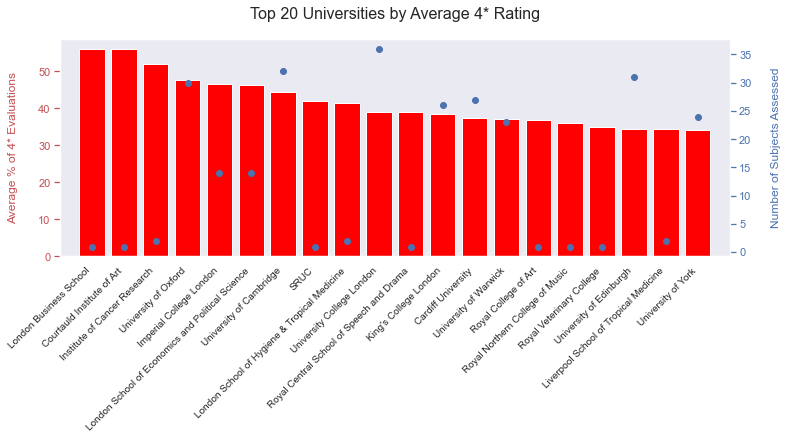

In [14]:
fig, axis1 = plt.subplots(figsize=(12, 4))
axis1.grid(False)
axis1.bar(x=result["Institution_Name"].astype(str), height=result["Average_4_Star_Percentage"], color='red')
axis1.set_title("Top 20 Universities by Average 4* Rating", pad = 20, fontsize = 16)
axis1.set_ylabel("Average % of 4* Evaluations", labelpad=20, color = 'r', fontsize = 12)
axis1.set_xticklabels(result["Institution_Name"].astype(str), horizontalalignment = "right")
axes2 = axis1.twinx()
axes2.plot(result["COUNT(Unit_of_Assessment_Name)"], marker = "o", linestyle = "")
axes2.set_ylabel("Number of Subjects Assessed", labelpad=20, color = 'b', fontsize = 12)
axes2.grid(False)
_ = axis1.set_xlim(-1, 20)
axis1.tick_params(axis='y', colors='r')
axis1.tick_params(axis='x', labelsize = 10, rotation = 45)
axes2.tick_params(axis='y', colors='b')

## What about the institutions which were the weakest performers in this assessment?

The unclassified rating is the lowest possible rating in the assessment, and is given for 'quality that falls below the standard of nationally recognised work'.

We can find the universities whose submissions got the highest average percentage of Unclassified ratings. By this measure, Writtle College is the worst performing institution in the dataset, with an average of 35% of submissions receiving Unclassified ratings across its two subject areas.

Based on the previous chart, we might conclude that universities which specialise in one or a small number of subjects would perform better: the two universities with the highest average percentage of 4* evaluations were each assessed in only one subject. However, several of the universities with the highest percentage of Unclassified ratings also specialise in one subject. So, specialisation is no guarantee of quality.

In [15]:
result = pd.read_sql("""
WITH Unclassified_Percentages AS (SELECT DISTINCT Institution_Name, 
                                         Unit_of_Assessment_Name,
                                         Star_Rating,
                                         Percentage
                                  FROM REF_Results
                                  WHERE Profile = "Overall" AND Star_Rating = "unclassified")
                                              
SELECT Institution_Name,
       COUNT(Unit_of_Assessment_Name),
       CAST(SUM(Percentage) AS REAL) / COUNT(Star_Rating) AS Average_Unclassified_Percentage
FROM Unclassified_Percentages
GROUP BY Institution_Name
ORDER BY CAST(SUM(Percentage) AS REAL) / COUNT(Star_Rating) DESC
LIMIT 20;""", database)

<ipython-input-16-6954073e0042>:6: UserWarning: FixedFormatter should only be used together with FixedLocator
  axis1.set_xticklabels(result["Institution_Name"].astype(str), horizontalalignment = "right")


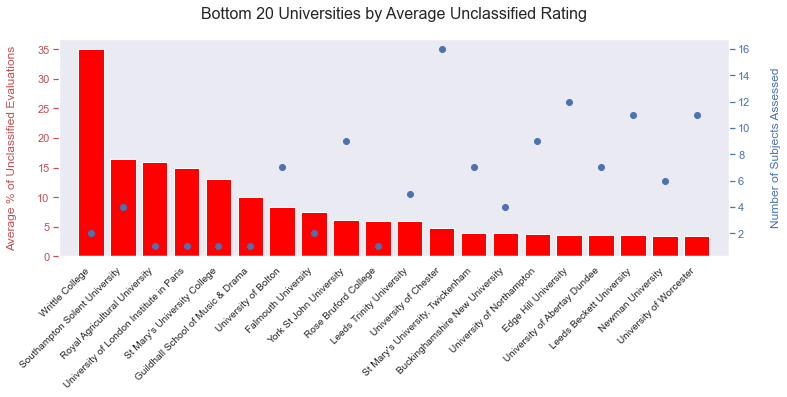

In [16]:
fig, axis1 = plt.subplots(figsize=(12, 4))
axis1.grid(False)
axis1.bar(x=result["Institution_Name"].astype(str), height=result["Average_Unclassified_Percentage"], color='red')
axis1.set_title("Bottom 20 Universities by Average Unclassified Rating", pad = 20, fontsize = 16)
axis1.set_ylabel("Average % of Unclassified Evaluations", labelpad=20, color = 'r', fontsize = 12)
axis1.set_xticklabels(result["Institution_Name"].astype(str), horizontalalignment = "right")
axes2 = axis1.twinx()
axes2.plot(result["COUNT(Unit_of_Assessment_Name)"], marker = "o", linestyle = "")
axes2.set_ylabel("Number of Subjects Assessed", labelpad=20, color = 'b', fontsize = 12)
axes2.grid(False)
_ = axis1.set_xlim(-1, 20)
axis1.tick_params(axis='y', colors='r')
axis1.tick_params(axis='x', labelsize = 10, rotation = 45)
axes2.tick_params(axis='y', colors='b')

## Which universities have the largest number of staff?

The REF results show how many full-time equivalent (FTE) staff members were submitted for the assessment. Which universities have submitted the highest staff numbers for assessment?

In [17]:
result = pd.read_sql("""
SELECT DISTINCT Institution_Name,
       SUM(FTE_Category_A_staff_submitted) AS Number_of_Staff_FTE
FROM REF_Results
WHERE Profile = "Overall" AND Star_Rating = "4*"
GROUP BY Institution_Name
ORDER BY SUM(FTE_Category_A_staff_submitted) DESC
LIMIT 20;""", database)

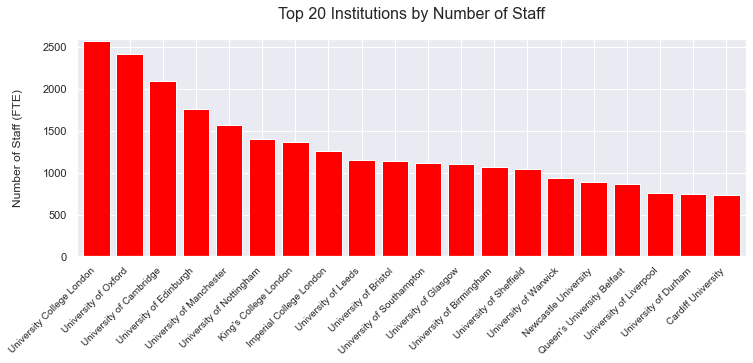

In [18]:
plt.figure(figsize=(12, 4))
plt.bar(x=result["Institution_Name"].astype(str), height=result["Number_of_Staff_FTE"], color='red')
plt.title("Top 20 Institutions by Number of Staff", pad = 20, fontsize = 16)
plt.ylabel("Number of Staff (FTE)", labelpad=20, fontsize = 12)
_ = plt.xticks(rotation = 45, ha = "right", fontsize = 10)
plt.margins(0.01, 0.01)

## And the smallest number of staff?

In [19]:
result = pd.read_sql("""
SELECT DISTINCT Institution_Name,
       SUM(FTE_Category_A_staff_submitted) AS Number_of_Staff_FTE
FROM REF_Results
WHERE Profile = "Overall" AND Star_Rating = "4*"
GROUP BY Institution_Name
ORDER BY SUM(FTE_Category_A_staff_submitted) ASC
LIMIT 20;""", database)

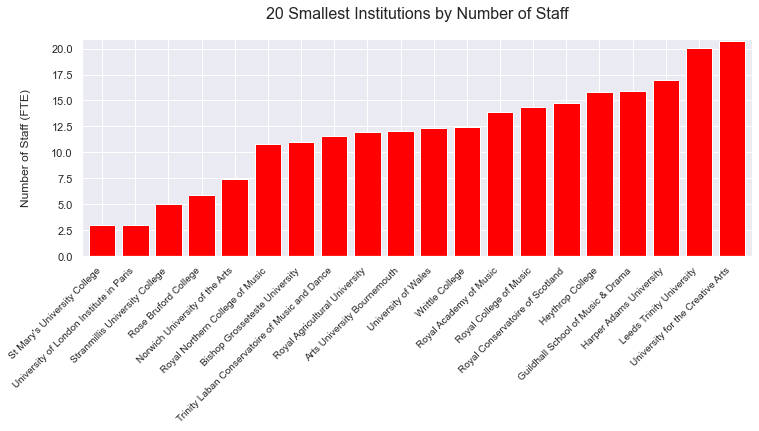

In [20]:
plt.figure(figsize=(12, 4))
plt.bar(x=result["Institution_Name"].astype(str), height=result["Number_of_Staff_FTE"], color='red')
plt.title("20 Smallest Institutions by Number of Staff", pad = 20, fontsize = 16)
plt.ylabel("Number of Staff (FTE)", labelpad=20, fontsize = 12)
_ = plt.xticks(rotation = 45, ha = "right", fontsize = 10)
plt.margins(0.01, 0.01)

## Which universities are the most collaborative?

Institutions were able to prepare joint submissions with another institution and submit this to the assessment. A total of 23 universities prepared joint submissions.

The University of Edinburgh entered the highest number of joint submissions, at a total of six. Edinburgh also had the highest number of partners, at three. 

In [21]:
pd.read_sql("""SELECT Institution_Name,
                      COUNT(DISTINCT Unit_of_Assessment_Name) AS Number_of_Joint_Submissions,
                      COUNT(DISTINCT Joint_submission) AS Number_of_Partners
               FROM REF_Results
               WHERE Joint_submission LIKE "%joint%"
               GROUP BY Institution_Name
               ORDER BY Number_of_Joint_Submissions DESC;""", database)

,Institution_Name,Number_of_Joint_Submissions,Number_of_Partners
0,University of Edinburgh,6,3
1,Heriot-Watt University,3,1
2,Bangor University,3,2
3,University of Wales Trinity Saint David,2,2
4,University of St Andrews,2,1
5,University College London,2,1
6,Liverpool School of Tropical Medicine,2,2
7,Cardiff Metropolitan University,2,2
8,Birkbeck College,2,1
9,Aberystwyth University,2,1


In [22]:
pd.read_sql("""
    SELECT Institution_Name,
           Unit_of_Assessment_Name,
           Joint_submission
    FROM REF_Results
    WHERE Joint_submission LIKE "%joint%"
    GROUP BY Institution_Name, Unit_of_Assessment_Name, Joint_submission;""", database)

,Institution_Name,Unit_of_Assessment_Name,Joint_submission
0,Aberystwyth University,"Agriculture, Veterinary and Food Science",(joint submission with Bangor University)
1,Aberystwyth University,Earth Systems and Environmental Sciences,(joint submission with Bangor University)
2,Bangor University,"Agriculture, Veterinary and Food Science",(joint submission with Aberystwyth University)
3,Bangor University,Earth Systems and Environmental Sciences,(joint submission with Aberystwyth University)
4,Bangor University,"Sport and Exercise Sciences, Leisure and Tourism",(joint submission with Cardiff Metropolitan Un...
5,Birkbeck College,Biological Sciences,(joint submission with University College London)
6,Birkbeck College,Earth Systems and Environmental Sciences,(joint submission with University College London)
7,Cardiff Metropolitan University,"Art and Design: History, Practice and Theory",(joint submission with University of South Wal...
8,Cardiff Metropolitan University,"Sport and Exercise Sciences, Leisure and Tourism",(joint submission with Bangor University)
9,Heriot-Watt University,"Architecture, Built Environment and Planning",(joint submission with University of Edinburgh)


## How to find the best university for you

If you're trying to decide on a university and course, you can tailor this search to see which universities performed the best in the in the subject you're interested in.

As a reminder, these are the subjects covered by the assessment. You can amend the WHERE clause in the next code block to focus your search.

In [23]:
pd.read_sql("""SELECT DISTINCT Unit_of_Assessment_Name
               FROM REF_Results
               ORDER BY Unit_of_Assessment_Name ASC;""", database)

,Unit_of_Assessment_Name
0,"Aeronautical, Mechanical, Chemical and Manufac..."
1,"Agriculture, Veterinary and Food Science"
2,"Allied Health Professions, Dentistry, Nursing ..."
3,Anthropology and Development Studies
4,"Architecture, Built Environment and Planning"
5,Area Studies
6,"Art and Design: History, Practice and Theory"
7,Biological Sciences
8,Business and Management Studies
9,Chemistry


In [24]:
pd.read_sql("""
SELECT Institution_Name,
       Unit_of_Assessment_Name,
       CAST(Percentage AS INTEGER) AS 'Percentage Overall 4* Ratings'
FROM REF_Results
--change the last part depending on the subject of interest
WHERE Star_Rating = "4*" AND Profile = "Overall" AND Unit_of_Assessment_Name = "Modern Languages and Linguistics" 
ORDER BY CAST(Percentage AS INTEGER) DESC
LIMIT 10;""", database)

,Institution_Name,Unit_of_Assessment_Name,Percentage Overall 4* Ratings
0,Queen Mary University of London,Modern Languages and Linguistics,62
1,University of York,Modern Languages and Linguistics,45
2,University of Edinburgh,Modern Languages and Linguistics,45
3,University of Manchester,Modern Languages and Linguistics,41
4,Bangor University,Modern Languages and Linguistics,41
5,University of Cambridge,Modern Languages and Linguistics,40
6,University of Essex,Modern Languages and Linguistics,40
7,Queen's University Belfast,Modern Languages and Linguistics,40
8,University of Kent,Modern Languages and Linguistics,39
9,University of Southampton,Modern Languages and Linguistics,39
